In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import numpy as np
from PIL import Image
from torch.utils.data import Subset, random_split, ConcatDataset
import optuna
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [17]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, device, image_sizes= 299, kernel_size=3, max_pool_size=2, lr=0.001, epochs=3):
        """
        CNN contructor
        inputs:
        device - device in which the cnn will be executed
        kernel_size (hiperparameter) - this is the size that will be used in the convolution layers
            type: int, a single number will work with a grid of size n x n
        max_pool_size - this is the size of the pooling layer
        lr (hiperparameter) - the learning rate that will be used to train the cnn
        epochs (hiperparmeter) - the amount of iterations that will be used to train the cnn
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=max_pool_size, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=max_pool_size, stride=2)
        self.fc1 = nn.Linear(32 * (image_sizes//(max_pool_size**2))**2, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)

        self.lr = lr
        self.epochs = epochs
        self.device = device


    def forward(self, x):
        """
        The forward function is used in the training to understand the infrastructure
        of the proposed model
        """
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x
    
    def train_cnn(self, train_dataset, train_labels):
        """
        Method to train the cnn based on the inputs:
        train_dataset - tensor with the information of the pixels of the images
        train_labels - tesnro with the category of each of the images frrom the train_dataset
        """
        # Set the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), self.lr)

        # Create a data loader for the training dataset
        train_loader = DataLoader(dataset=list(zip(train_dataset, train_labels)), batch_size=16, shuffle=True)

        self.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for images, labels in train_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()

                outputs = self(images)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(train_dataset)
            print("Running loss: ", running_loss)
            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {epoch_loss:.4f}")

    def predict(self, test_dataset):
        predictions = []
        self.eval() 
        # Create a data loader for the training dataset
        dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

        with torch.no_grad(): 
            for inputs in dataloader:
                # Forward pass through the model to obtain predictions
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.tolist())
        
        return predictions


In [135]:
# load images from additional dataset to void bias
# https://www.kaggle.com/datasets/gibi13/pneumonia-covid19-image-dataset

"""
# Define the input folder with the original images
input_folder = "images/additional_dataset/"

# Define the output folder to save the resized images
output_folder = "images/analysis_dataset/"

# Define the target size for the resized images
target_size = (299, 299)

categories = ['COVID', 'Viral_Pneumonia']

for category in categories:
    # Get the list of files in the input folder
    file_list = os.listdir(os.path.join(input_folder, category))

    # Iterate over each file in the input folder
    for file_name in file_list:
        input_path = os.path.join(input_folder, category, file_name)
        
        image = Image.open(input_path)
        resized_image = image.resize(target_size)
        output_path = os.path.join(output_folder, category, file_name)
        
        # Save the resized image to the output folder
        resized_image.save(output_path)
        image.close()
"""

In [23]:
# delete images from cropped dataset

"""
cropped_images_folder = 'images/cropped_dataset/'
categories = {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}

for category in categories.keys():
    folder_path = os.path.join(cropped_images_folder, category)

    file_list = os.listdir(folder_path)

    for file_name in file_list:
        file_path = os.path.join(cropped_images_folder, category, file_name)
        os.remove(file_path)
"""

In [24]:
# Feature engineering
#   Crop images borders and ignore extra images on bias

# define a different folder to save the cropped images
original_images_folder = 'images/analysis_dataset/'
cropped_images_folder = 'images/cropped_dataset/'

# define the new size
target_size = (250, 250)

categories = {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}
category_amount = []

# get the amount of images for each category
for category in categories.keys():
    folder_path = os.path.join(original_images_folder, category)
    image_files = os.listdir(folder_path)
    category_amount.append(len(image_files))

print("Amount of images in analysis dataset:")
print(f"\tCOVID\t\t\t : {category_amount[0]}\n \
        Lung_Opacity\t\t : {category_amount[1]}\n \
        Normal\t\t\t : {category_amount[2]}\n \
        Viral_Pneumonia\t : {category_amount[3]}\n")

max_training = min(category_amount)
print("Maximum amount of images to use in the training: ", min(category_amount))

# crop and save the cropped images
for category in categories.keys():

    cat_files = os.listdir(os.path.join(original_images_folder, category))

    for i, file in enumerate(cat_files):

        if i == max_training: break
        # constructing image path
        input_path = os.path.join(original_images_folder, category, file)
        image = Image.open(input_path)

        if image.size[0] < 299 or image.size[1] < 299:
            continue
        
        # get original image size and calculate borders
        width, height = image.size
        left = (width - target_size[0]) // 2
        upper = (height - target_size[1]) // 2
        right = left + target_size[0]
        lower = upper + target_size[1]

        # crop the image
        cropped_image = image.crop((left, upper, right, lower))
        output_path = os.path.join(cropped_images_folder, category, file)
        cropped_image.save(output_path)
        image.close()

Amount of images in analysis dataset:
	COVID			 : 4596
         Lung_Opacity		 : 6012
         Normal			 : 10192
         Viral_Pneumonia	 : 2857

Maximum amount of images to use in the training:  2857


In [7]:
# Feature engineering
#   Normalize the pixel values of the images

parent_folder_path = 'images/cropped_dataset/'
categories = {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}
arrays = []
category_amount = []

# get the category with the least images
for category in categories.keys():
    folder_path = os.path.join(parent_folder_path, category)
    image_files = os.listdir(folder_path)
    category_amount.append(len(image_files))

max_training = min(category_amount)

# convert the images into a pytorch dataset
for cat_folder, value in categories.items():

    folder_path = os.path.join(parent_folder_path, cat_folder)
    image_files = os.listdir(folder_path)

    for i, file_name in enumerate(image_files):

        if i >= max_training: break
        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        image_array = np.array(image)

        if image.size != (250, 250):
            print(file_path, " IS NOT 250x250, it is: ", image.size)
            continue

        if image_array.shape != (250, 250):
            image_array = np.dot(image_array[..., :3], [0.2989, 0.5870, 0.1140])

        arrays.append(image_array)

arrays = arrays/ np.max(arrays)
image_data = np.stack(arrays, axis=0)
image_data = image_data.reshape(len(image_data), 1, 250, 250)
image_data = torch.from_numpy(image_data).to(torch.float32)


# Stratify - get a random amount of values from
train_perc = 0.8

train_size = int(train_perc * max_training)
test_size = max_training - train_size

# Get the training and testing dataset
train_dataset = []
test_dataset = []
train_labels = []
test_labels = []
for category, value in categories.items():
    train_cat_dataset, test_cat_dataset = random_split(image_data[value*max_training:(value+1)*max_training], [train_size, test_size])
    train_dataset.append(train_cat_dataset)
    test_dataset.append(test_cat_dataset)
    train_cat_labels = [value] * train_size
    train_labels += train_cat_labels
    test_cat_labels = [value] * test_size
    test_labels += test_cat_labels

# Convert the lists into the types needed to train the models
train_dataset = ConcatDataset(train_dataset)
test_dataset = ConcatDataset(test_dataset)
train_labels = torch.from_numpy(np.array(train_labels)).to(torch.long)
test_labels = torch.from_numpy(np.array(test_labels))


In [18]:
# Training

def objective(trial):
    # define hyperparameters to be optimized
    lr = trial.suggest_float('lr', 0.00001, 0.00001, log=True)
    epochs = trial.suggest_int('epochs', 3, 3)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN(epochs=epochs, lr=lr, device=device, image_sizes=250).to(device)

    model.train_cnn(train_dataset, train_labels)   
    predictions = model.predict(test_dataset)
    
    accuracy = accuracy_score(test_labels, predictions)

    return accuracy

# Create optuna study and optimize the objetive function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)

# Print the best hyperparameters and the best objective value
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_value)


#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = CNN(epochs=4, lr=0.0001, device=device, image_sizes=250).to(device)

#model.train_cnn(train_dataset, train_labels)


[I 2023-05-19 07:36:15,987] A new study created in memory with name: no-name-c5160e2b-9415-4a33-9b20-54e6104ec450


Running loss:  4.293701171875
Epoch [1/3], Loss: 0.0005
Running loss:  3.5685153007507324
Epoch [2/3], Loss: 0.0004
Running loss:  1.6341841220855713
Epoch [3/3], Loss: 0.0002


[I 2023-05-19 07:48:05,240] Trial 0 finished with value: 0.25524475524475526 and parameters: {'lr': 1e-05, 'epochs': 3}. Best is trial 0 with value: 0.25524475524475526.


Best Hyperparameters:  {'lr': 1e-05, 'epochs': 3}
Best Accuracy:  0.25524475524475526


In [92]:
predictions = model.predict(test_dataset)
print("Model Preductions: \n", predictions)
print("Real categories: \n", test_labels)

correct = 0
incorrect = 0
for i in range(len(predictions)):
    if predictions[i] == test_labels[i]:
        correct += 1
    else:
        incorrect += 1

print("Correct: ", correct, " Incorrect: ", incorrect)

Model Preductions: 
 [1, 0, 3, 0, 0, 3, 1, 2, 1, 1, 3, 2, 1, 2, 3, 2, 0, 3, 2, 3, 2, 0, 0, 3, 1, 3, 2, 2, 0, 2, 2, 1, 2, 1, 3, 0, 1, 2, 2, 3, 2, 0, 3, 3, 2, 3, 0, 0, 0, 2, 1, 3, 2, 3, 0, 2, 0, 2, 1, 0, 0, 3, 2, 1, 0, 3, 1, 2, 1, 0, 3, 2, 0, 3, 1, 3, 1, 3, 0, 1, 3, 2, 2, 2, 0, 0, 0, 3, 2, 3, 1, 1, 3, 3, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 1, 2, 3, 2, 0, 2, 3, 2, 1, 0, 3, 3, 2, 3, 3, 0, 1, 3, 1, 0, 0, 2, 3, 1, 0, 0, 0, 2, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 3, 0, 1, 0, 1, 0, 0, 2, 3, 2, 0, 3, 2, 3, 0, 3, 2, 3, 2, 2, 2, 1, 0, 1, 1, 1, 1, 3, 3, 1, 3, 2, 3, 3, 2, 3, 0, 0, 2, 3, 2, 3, 3, 1, 0, 2, 3, 3, 0, 1, 2, 1, 1, 3, 0, 2, 1, 2, 0, 2, 0, 2, 1, 1, 3, 1, 2, 3, 2, 3, 1, 2, 2, 0, 0, 0, 1, 2, 2, 3, 2, 0, 0, 0, 3, 0, 3, 3, 2, 0, 1, 0, 2, 3, 3, 1, 3, 1, 0, 2, 3, 3, 0, 1, 0, 2, 1, 2, 0, 0, 1, 0, 3, 1, 1, 3, 3, 2, 0, 0, 0, 2, 0, 1, 3, 0, 2, 3, 2, 3, 2, 0, 2, 1, 3, 2, 2, 2, 0, 2, 1, 2, 3, 0, 0, 1, 2, 2, 0, 0, 1, 1, 3, 0, 2, 1, 3, 0, 0, 2, 0, 3, 1, 2, 2, 1, 0, 2, 2, 3, 1, 0, 0, 3, 0, 0, 2, 3, 1, 2, 0, 3, 

[[151 102 177 142]
 [171  86 162 153]
 [155 102 169 146]
 [167 103 146 156]]
Accuracy:  0.24562937062937062
Precision:  [0.23447205 0.21882952 0.25840979 0.26130653]
Recall:  [0.26398601 0.15034965 0.29545455 0.27272727]
F1 score:  [0.24835526 0.17823834 0.27569331 0.26689478]
General AUC: 0.49708624708624716


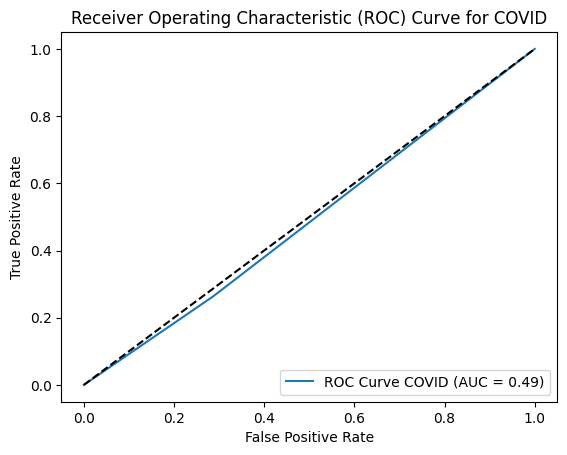

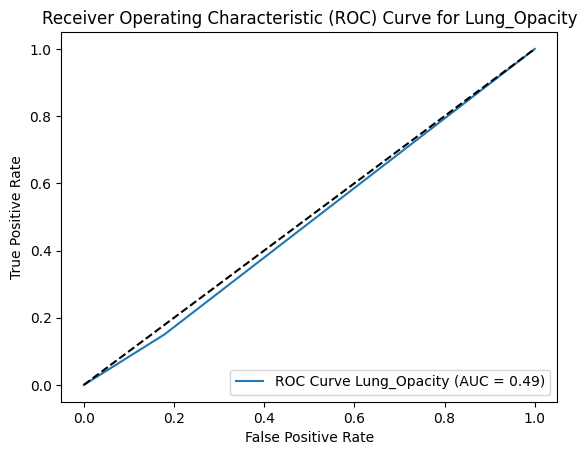

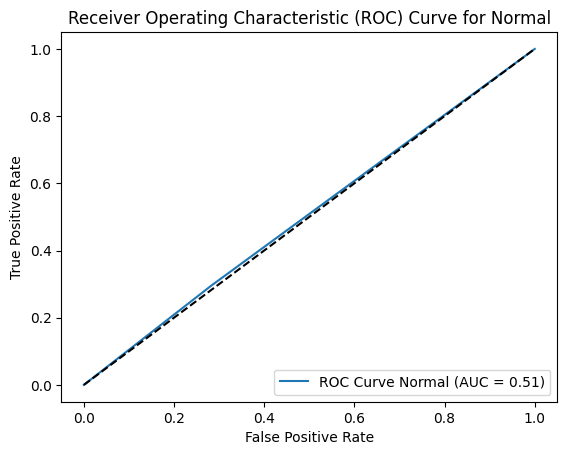

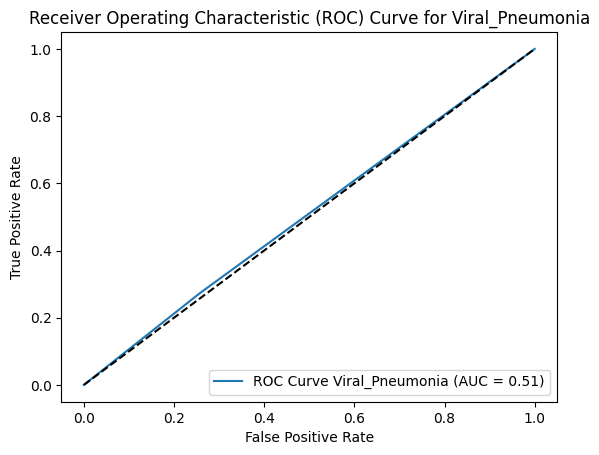

In [115]:
# get the metrics
print(confusion_matrix(test_labels, predictions))
print("Accuracy: ", accuracy_score(test_labels, predictions))
print("Precision: ", precision_score(test_labels, predictions, average=None))
print("Recall: ", recall_score(test_labels, predictions, average=None))
print("F1 score: ", f1_score(test_labels, predictions, average=None))

test_label_mat = []
predictions_mat = []

covid_true = []
lung_op_true = []
normal_true = []
viral_pneu_true = []

covid_pred = []
lung_op_pred = []
normal_pred = []
viral_pneu_pred = []

for i in range(len(test_labels)):
    
    # y_test
    covid_true.append(test_labels[i] == 0)
    lung_op_true.append(test_labels[i] == 1)
    normal_true.append(test_labels[i] == 2)
    viral_pneu_true.append(test_labels[i] == 3)

    # predictions
    covid_pred.append(predictions[i] == 0)
    lung_op_pred.append(predictions[i] == 1)
    normal_pred.append(predictions[i] == 2)
    viral_pneu_pred.append(predictions[i] == 3)

test_label_mat.append(covid_true)
test_label_mat.append(lung_op_true)
test_label_mat.append(normal_true)
test_label_mat.append(viral_pneu_true)

predictions_mat.append(covid_pred)
predictions_mat.append(lung_op_pred)
predictions_mat.append(normal_pred)
predictions_mat.append(viral_pneu_pred)


auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)

categories = {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}

for category, value in categories.items():

    fpr, tpr, thresholds = roc_curve(test_label_mat[value], predictions_mat[value])

    auc = roc_auc_score(test_label_mat[value], predictions_mat[value])

    plt.plot(fpr, tpr, label=f'ROC Curve {category} (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing the random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {category}')
    plt.legend(loc='lower right')
    plt.show()